<a href="https://colab.research.google.com/github/loganhooker02/hookermachinelearning/blob/main/assign4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [25]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import pandas as pd
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
import time

from torchvision import datasets
from torchvision import transforms

In [26]:
data_path = '../data-unversioned/p1ch7/'
cifar10 = datasets.CIFAR10(data_path, train=True, download=True)
cifar10_val = datasets.CIFAR10(data_path, train=False, download=True)

Files already downloaded and verified
Files already downloaded and verified


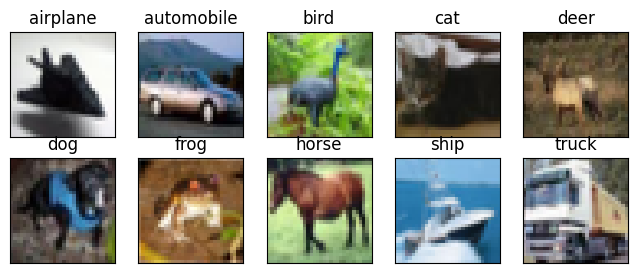

In [27]:
classes = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
fig = plt.figure(figsize=(8,3))
num_classes = 10
for i in range(num_classes):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    ax.set_title(classes[i])
    img = next(img for img, label in cifar10 if label == i)
    plt.imshow(img)
plt.show()

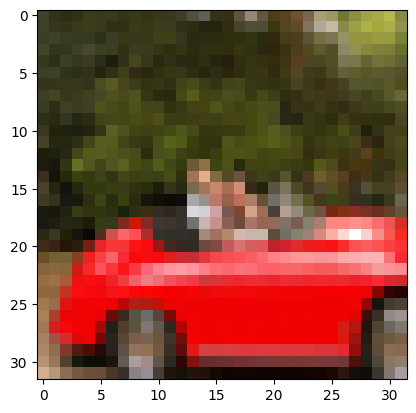

In [28]:
img, label = cifar10[99]
img, label, classes[label]
plt.imshow(img)

In [29]:
#turn image into a tensor
toTensor = transforms.ToTensor()
img_t = toTensor(img)
img_t.shape

torch.Size([3, 32, 32])

In [30]:
#convert the rest
cifar10_t = datasets.CIFAR10(data_path, train=True, download = False, transform = transforms.ToTensor())


In [31]:
#normalize data
imgs = torch.stack([img_t for img_t, _ in cifar10_t], dim=3)
#use these values for normalizing data
print(imgs.view(3, -1).mean(dim=1))
print(imgs.view(3, -1).std(dim=1))
transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470,0.2435,0.2616))
c10_tran = datasets.CIFAR10(data_path, train=True, download=False,
transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470,0.2435,0.2616))]))
c10_tran_val = datasets.CIFAR10(
    data_path, train=False, download=False,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470,0.2435,0.2616))]))

c10_tran

tensor([0.4914, 0.4822, 0.4465])
tensor([0.2470, 0.2435, 0.2616])


Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ../data-unversioned/p1ch7/
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.247, 0.2435, 0.2616))
           )

PROBLEM 1A

In [32]:
#create neural network with 1 hidden level
def softmax(x):
    return torch.exp(x) / torch.exp(x).sum()

n_out = 10
model = nn.Sequential(nn.Linear(3072, 512), nn.ReLU(), nn.Linear(512, n_out), nn.LogSoftmax(dim=1))

In [33]:
#declare whether to use gpu or cpu for operations
device = torch.device('cuda')
#device = torch.device('cpu')
print(device)

cuda


In [34]:
train_loader = torch.utils.data.DataLoader(c10_tran, batch_size=64, shuffle=True)

In [35]:
model = model.to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-2)
loss_fn = nn.NLLLoss()
n_epochs = 100
losses = []

In [36]:
#training
start_time = time.time() #time training starts
for epoch in range(n_epochs):
    for imgs, labels in train_loader:
        imgs = imgs.to(device)
        labels = labels.to(device)
        outputs = model(imgs.view(imgs.shape[0], -1))
        loss = loss_fn(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    losses.append(float(loss))
    print("Epoch: %d, Loss: %f" % (epoch, float(loss)))
end_time = time.time()
train_time = end_time - start_time
print("Training Time:", train_time, "seconds")

Epoch: 0, Loss: 10.982142
Epoch: 1, Loss: 9.962327
Epoch: 2, Loss: 12.614442
Epoch: 3, Loss: 23.887697
Epoch: 4, Loss: 6.223987
Epoch: 5, Loss: 5.279628
Epoch: 6, Loss: 7.029958
Epoch: 7, Loss: 4.045281
Epoch: 8, Loss: 15.968662
Epoch: 9, Loss: 7.932575
Epoch: 10, Loss: 6.697722
Epoch: 11, Loss: 7.516436
Epoch: 12, Loss: 5.931352
Epoch: 13, Loss: 10.206933
Epoch: 14, Loss: 6.222546
Epoch: 15, Loss: 15.934528
Epoch: 16, Loss: 11.407566
Epoch: 17, Loss: 5.629914
Epoch: 18, Loss: 8.609583
Epoch: 19, Loss: 3.778028
Epoch: 20, Loss: 5.438622
Epoch: 21, Loss: 5.937063
Epoch: 22, Loss: 7.488335
Epoch: 23, Loss: 5.425611
Epoch: 24, Loss: 3.288521
Epoch: 25, Loss: 10.698371
Epoch: 26, Loss: 7.045447
Epoch: 27, Loss: 12.708130
Epoch: 28, Loss: 13.134613
Epoch: 29, Loss: 4.643086
Epoch: 30, Loss: 9.359540
Epoch: 31, Loss: 3.593436
Epoch: 32, Loss: 5.429687
Epoch: 33, Loss: 1.975449
Epoch: 34, Loss: 3.363566
Epoch: 35, Loss: 4.642802
Epoch: 36, Loss: 3.108607
Epoch: 37, Loss: 8.651737
Epoch: 38, L

In [37]:
#find training accuracy
train_load = torch.utils.data.DataLoader(c10_tran, batch_size=64, shuffle = False);
train_correct = 0
train_total = 0

with torch.no_grad():
    for imgs, labels in train_loader:
        imgs = imgs.to(device)
        labels = labels.to(device)

        outputs = model(imgs.view(imgs.shape[0], -1))
        _, predicted = torch.max(outputs, dim=1)
        train_total += labels.shape[0]
        train_correct += int((predicted == labels).sum())

print("Training Accuracy: %f" % (train_correct / train_total))

# validation Accuracy
val_load = torch.utils.data.DataLoader(c10_tran_val, batch_size=64,shuffle=False)
val_correct = 0
val_total = 0

val_loss = []

with torch.no_grad():
    for imgs, labels in val_load:
        imgs = imgs.to(device)
        labels = labels.to(device)

        outputs = model(imgs.view(imgs.shape[0], -1))
        _, predicted = torch.max(outputs, dim=1)
        val_total += labels.shape[0]
        val_correct += int((predicted == labels).sum())

print("Validation Accuracy: %f" % (val_correct / val_total))

Training Accuracy: 0.389020
Validation Accuracy: 0.314800


In [38]:
# Save Model
torch.save(model.state_dict(), 'CIFAR10_1Layer.pt')

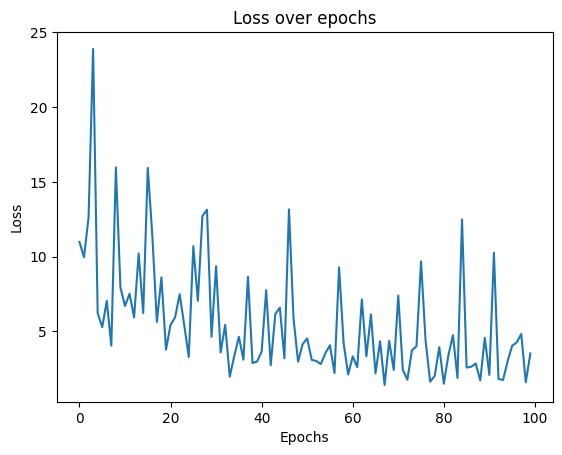

In [39]:
#plot loss

plt.figure(1)
plt.plot(range(n_epochs), losses)
plt.title("Loss over epochs")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

PART B

In [40]:
model_b = nn.Sequential(
     nn.Linear(3072, 1024),
     nn.ReLU(),
     nn.Linear(1024, 512),
     nn.ReLU(),
     nn.Linear(512, 128),
     nn.ReLU(),
     nn.Linear(128, 10)) #step down the layers using values of 2^n
model_b

Sequential(
  (0): Linear(in_features=3072, out_features=1024, bias=True)
  (1): ReLU()
  (2): Linear(in_features=1024, out_features=512, bias=True)
  (3): ReLU()
  (4): Linear(in_features=512, out_features=128, bias=True)
  (5): ReLU()
  (6): Linear(in_features=128, out_features=10, bias=True)
)

In [41]:
train_loader_b = torch.utils.data.DataLoader(c10_tran, batch_size=64, shuffle=True)


In [42]:
#remaining variables before training
model_b = model_b.to(device)
optimizer_b = optim.SGD(model_b.parameters(), lr=1e-3)
loss_fn_b = nn.CrossEntropyLoss()
n_epochs = 300


losses_b = []

In [43]:
start_time = time.time() #record start time
for epoch in range(n_epochs):
    for imgs, labels in train_loader_b:
        imgs = imgs.to(device)
        labels = labels.to(device)
        outputs = model_b(imgs.view(imgs.shape[0], -1))
        loss = loss_fn_b(outputs, labels)

        optimizer_b.zero_grad()
        loss.backward()
        optimizer_b.step()

    losses_b.append(float(loss))
    if epoch %10 == 0 or epoch == 300:
        print("Epoch: %d, Loss: %f" % (epoch, float(loss)))
end_time = time.time()
train_time = end_time - start_time
print("Training Time:", train_time, "seconds")

Epoch: 0, Loss: 2.270740
Epoch: 10, Loss: 1.696547
Epoch: 20, Loss: 1.394884
Epoch: 30, Loss: 1.311787
Epoch: 40, Loss: 1.263991
Epoch: 50, Loss: 1.016770
Epoch: 60, Loss: 0.934428
Epoch: 70, Loss: 0.736514
Epoch: 80, Loss: 0.506793
Epoch: 90, Loss: 0.402064
Epoch: 100, Loss: 0.622643
Epoch: 110, Loss: 0.493321
Epoch: 120, Loss: 0.156531
Epoch: 130, Loss: 0.414835
Epoch: 140, Loss: 0.290733
Epoch: 150, Loss: 0.108637
Epoch: 160, Loss: 0.090629
Epoch: 170, Loss: 0.079002
Epoch: 180, Loss: 0.029652
Epoch: 190, Loss: 0.053223
Epoch: 200, Loss: 0.031988
Epoch: 210, Loss: 0.021099
Epoch: 220, Loss: 0.033515
Epoch: 230, Loss: 0.011824
Epoch: 240, Loss: 0.010730
Epoch: 250, Loss: 0.020383
Epoch: 260, Loss: 0.011208
Epoch: 270, Loss: 0.006316
Epoch: 280, Loss: 0.006864
Epoch: 290, Loss: 0.002683
Training Time: 4279.566915512085 seconds


In [44]:
# Training Accuracy
train_loader = torch.utils.data.DataLoader(c10_tran, batch_size=64, shuffle=False)
train_correct = 0
train_total = 0

with torch.no_grad():
    for imgs, labels in train_loader:
        imgs = imgs.to(device)
        labels = labels.to(device)

        outputs = model_b(imgs.view(imgs.shape[0], -1))
        _, predicted = torch.max(outputs, dim=1)
        train_total += labels.shape[0]
        train_correct += int((predicted == labels).sum())

print("Training Accuracy: %f" % (train_correct / train_total))

# Validation Accuracy
val_loader = torch.utils.data.DataLoader(c10_tran_val, batch_size=64, shuffle=False)
val_correct = 0
val_total = 0

val_loss_b = []

with torch.no_grad():
    for imgs, labels in val_loader:
        imgs = imgs.to(device)
        labels = labels.to(device)

        outputs = model_b(imgs.view(imgs.shape[0], -1))
        _, predicted = torch.max(outputs, dim=1)
        val_total += labels.shape[0]
        val_correct += int((predicted == labels).sum())

print("Validation Accuracy: %f" % (val_correct / val_total))

Training Accuracy: 0.999980
Validation Accuracy: 0.522900


In [45]:
# Save Model
torch.save(model_b.state_dict(), 'CIFAR10_3Layer.pt')

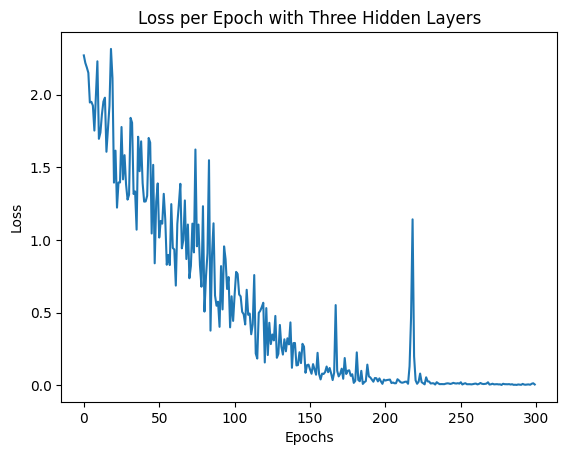

In [46]:
# Plot Loss
plt.figure(1)
plt.plot(range(n_epochs), losses_b)
plt.title("Loss per Epoch with Three Hidden Layers")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()